In [125]:
import sys
import numpy as np
import pandas as pd 
from datetime import timedelta, date
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('ticks')
sns.set(rc={'figure.figsize':(13.7,9.27)})
import warnings
warnings.filterwarnings('ignore')
import os
import folium
import pandas as pd
from IPython.display import display
from folium import Popup
import calendar

## Lecture et concaténation de tous les fichiers 

In [126]:
allfiles = os.listdir('./data/data valid/')
li = []

for file in allfiles : 
    print(file)
    file = './data/data valid/' + file 
    if file[-3:] == 'csv':
        data = pd.read_csv(file, header=0, sep=';')
        data['JOUR'] = pd.to_datetime(data['JOUR'])
        li.append(data)
    else:
        data = pd.read_csv(file, header=0, sep='\t')
        data['JOUR'] = pd.to_datetime(data['JOUR'])
        li.append(data)

dt = pd.concat(li, axis=0, ignore_index=True)

2015S2_NB_FER.csv
2018S1_NB_FER.txt
2017S2_NB_FER.txt
2016S2_NB_FER.txt
validations-sur-le-reseau-ferre-nombre-de-validations-par-jour-1er-semestre-2019.csv
2016S1_NB_FER.txt
2017S1_NB_FER.txt
2015S1_NB_FER.csv


## Modification des types 

In [127]:
dt.head()

,JOUR,CODE_STIF_TRNS,CODE_STIF_RES,CODE_STIF_ARRET,LIBELLE_ARRET,ID_REFA_LDA,CATEGORIE_TITRE,NB_VALD
0,2015-01-07,100,110,1,PORTE MAILLOT,71379,AMETHYSTE,241
1,2015-01-07,100,110,1,PORTE MAILLOT,71379,AUTRE TITRE,215
2,2015-01-07,100,110,1,PORTE MAILLOT,71379,FGT,518
3,2015-01-07,100,110,1,PORTE MAILLOT,71379,IMAGINE R,2556
4,2015-01-07,100,110,1,PORTE MAILLOT,71379,NAVIGO,14463


In [128]:
dt

,JOUR,CODE_STIF_TRNS,CODE_STIF_RES,CODE_STIF_ARRET,LIBELLE_ARRET,ID_REFA_LDA,CATEGORIE_TITRE,NB_VALD
0,2015-01-07,100,110,1,PORTE MAILLOT,71379,AMETHYSTE,241
1,2015-01-07,100,110,1,PORTE MAILLOT,71379,AUTRE TITRE,215
2,2015-01-07,100,110,1,PORTE MAILLOT,71379,FGT,518
3,2015-01-07,100,110,1,PORTE MAILLOT,71379,IMAGINE R,2556
4,2015-01-07,100,110,1,PORTE MAILLOT,71379,NAVIGO,14463
...,...,...,...,...,...,...,...,...
6300964,2015-06-30,810,802,905,VILLEPINTE,73547,AUTRE TITRE,49
6300965,2015-06-30,810,802,905,VILLEPINTE,73547,FGT,279
6300966,2015-06-30,810,802,905,VILLEPINTE,73547,IMAGINE R,308
6300967,2015-06-30,810,802,905,VILLEPINTE,73547,NAVIGO,1388


#### 8% des données ont la valeur "moins de 5" 

In [129]:
dt.loc[dt['NB_VALD'] == 'Moins de 5'].shape[0]/dt.shape[0]*100

9.450435321932229

In [130]:
dt.loc[dt['NB_VALD'] == 'Moins de 5', 'NB_VALD'] = 5
dt['NB_VALD'] = pd.to_numeric(dt['NB_VALD'])

In [131]:
dt['JOUR'] = dt['JOUR'].astype(str)

In [132]:
dt.dtypes

JOUR               object
CODE_STIF_TRNS      int64
CODE_STIF_RES      object
CODE_STIF_ARRET    object
LIBELLE_ARRET      object
ID_REFA_LDA        object
CATEGORIE_TITRE    object
NB_VALD             int64
dtype: object

In [133]:
dt_agg = pd.DataFrame(dt.groupby(["JOUR","LIBELLE_ARRET"])['NB_VALD'].sum().reset_index())

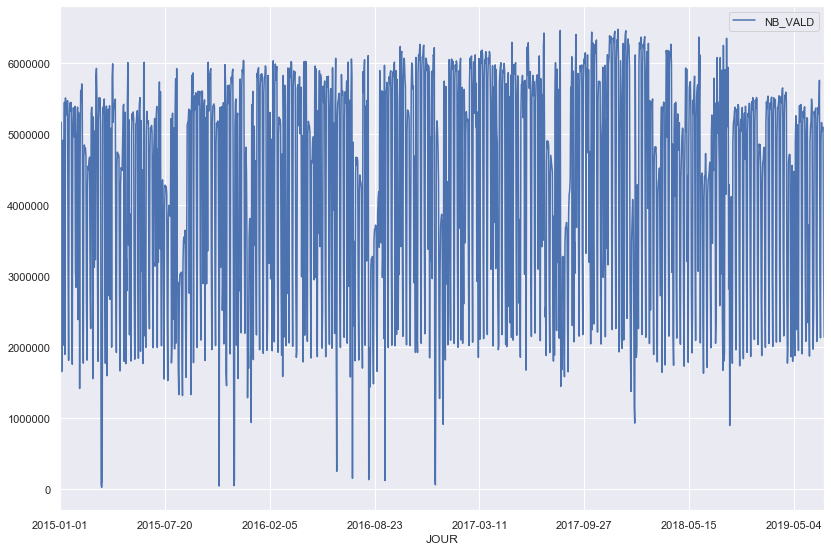

In [134]:
dt_agg.groupby('JOUR').sum().plot()

In [135]:
dt_agg

,JOUR,LIBELLE_ARRET,NB_VALD
0,2015-01-01,ABBESSES,750
1,2015-01-01,ABLON,118
2,2015-01-01,ACHERES-GRAND-CORMIER,18
3,2015-01-01,ACHERES-VILLE,482
4,2015-01-01,AEROPORT CHARLES DE GAULLE 1,1257
...,...,...,...
1026013,2019-06-30,VOLTAIRE (LEON BLUM),6306
1026014,2019-06-30,VOSVES,10
1026015,2019-06-30,VULAINES-SUR-SEINE-SAMOREAU,20
1026016,2019-06-30,WAGRAM,1840


In [136]:
dt_agg.shape

(1026018, 3)

In [137]:
dt_agg.to_csv('./data/validation_data_agg_2015_2019.csv')

## Merge positions

In [138]:
pos = pd.read_csv("data/positions-geographiques-des-stations-du-reseau-ratp.csv", sep=';')
dt2 = pos[['Name','Coordinates']].copy()

l = np.array(dt2["Coordinates"].str.split(",").tolist())
dt2["lon"] = l[:,0]
dt2["lat"] = l[:,1]
dt2.drop("Coordinates",axis=1, inplace=True)
#dt2["lon"] = dt2["lon"].str[0:6]
#dt2["lat"] = dt2["lat"].str[0:6]

#dt2.rename(columns={'Name':'LIBELLE_ARRET'}, inplace=True)
dt2['Name'] = dt2['Name'].str.lower()
dt2['Name'] = dt2['Name'].str.replace('[^\w]','')
dt2['Name'] = dt2['Name'].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')

dt2['lon'] = pd.to_numeric(dt2["lon"])
dt2['lat'] = pd.to_numeric(dt2["lat"])

dt2 = dt2.groupby('Name').mean().reset_index()
dt2.drop_duplicates(inplace=True)

dt2.head()

,Name,lon,lat
0,11novembre,48.849993,2.395659
1,11novembre1918,48.824212,2.516243
2,11novembrecourcellesuryvetterer,48.700031,2.099321
3,12fevrier1934,48.817827,2.308055
4,17octobre1961,48.898062,2.216702


In [139]:
dt_agg['Name'] = dt_agg['LIBELLE_ARRET'].str.lower()
dt_agg['Name'] = dt_agg['Name'].str.replace('[^\w]','')
dt_agg['Name'] = dt_agg['Name'].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')


In [140]:
dt_agg_pos = dt_agg.merge(dt2, how='left', on='Name')
dt_agg_pos.drop('Name',axis=1,inplace=True)
dt_agg_pos.head()

,JOUR,LIBELLE_ARRET,NB_VALD,lon,lat
0,2015-01-01,ABBESSES,750,48.884505,2.338365
1,2015-01-01,ABLON,118,NaN,NaN
2,2015-01-01,ACHERES-GRAND-CORMIER,18,48.955388,2.092457
3,2015-01-01,ACHERES-VILLE,482,48.970248,2.077672
4,2015-01-01,AEROPORT CHARLES DE GAULLE 1,1257,49.010400,2.561357


### Descriptif des gares

In [141]:
gare_desc = pd.read_csv('data/emplacement-des-gares-idf-data-generalisee.csv',delimiter = ';')

In [142]:
gare_desc = pd.read_csv('data/emplacement-des-gares-idf-data-generalisee.csv',delimiter = ';')
stations_desc = pd.read_csv('data/stations.csv',delimiter = ';')
gare_desc = gare_desc[['nom_long','res_com','mode_','principal']]

In [143]:
dt_agg_pos = pd.merge(dt_agg_pos,gare_desc,left_on='LIBELLE_ARRET',right_on='nom_long',how = 'left') 
dt_agg_pos = dt_agg_pos.drop(columns = ['nom_long'],axis = 1)

In [144]:
gare_desc.head()

,nom_long,res_com,mode_,principal
0,REUILLY-DIDEROT,M1 / M8,Metro,0
1,LOUVRE-RIVOLI,M1,Metro,0
2,LES MILONS,T2,Tramway,0
3,LYCEE HENRI SELLIER,T4,Tramway,0
4,PARMENTIER,M3,Metro,0


In [145]:
gare_desc[gare_desc['nom_long'].str.contains("NATION")]

,nom_long,res_com,mode_,principal
419,NATIONALE,M6,Metro,0
522,NATION,RER A / M1 / M2 / M6 / M9,RER / Metro,0
573,ASSEMBLEE NATIONALE,M12,Metro,0


## correspondances 

In [146]:
corr = pd.read_csv('data/correspondances.csv')
corr['Name'] = corr['stop_name'].str.lower()
corr['Name'] = corr['Name'].str.replace('[^\w]','')
corr['Name'] = corr['Name'].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')

dt_agg_pos['Name'] = dt_agg_pos['LIBELLE_ARRET'].str.lower()
dt_agg_pos['Name'] = dt_agg_pos['Name'].str.replace('[^\w]','')
dt_agg_pos['Name'] = dt_agg_pos['Name'].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')

dt_agg_pos_corr = dt_agg_pos.merge(corr, how='left', on='Name')
dt_agg_pos_corr.drop(['Name','stop_name'],axis=1,inplace=True)
dt_agg_pos_corr.head()

,JOUR,LIBELLE_ARRET,NB_VALD,lon,lat,res_com,mode_,principal,nb_metro,nb_rer
0,2015-01-01,ABBESSES,750,48.884505,2.338365,M12,Metro,0.0,1.0,0.0
1,2015-01-01,ABLON,118,NaN,NaN,RER C,RER,0.0,0.0,1.0
2,2015-01-01,ACHERES-GRAND-CORMIER,18,48.955388,2.092457,RER A,RER,0.0,0.0,1.0
3,2015-01-01,ACHERES-VILLE,482,48.970248,2.077672,LIGNE L / RER A,Train / RER,0.0,0.0,1.0
4,2015-01-01,AEROPORT CHARLES DE GAULLE 1,1257,49.010400,2.561357,RER B / CDGVAL,RER / Navette,0.0,0.0,1.0


## Referentiel des gares

In [147]:
ref = pd.read_csv('data/referentiel-gares-voyageurs.csv',delimiter = ';')
ref  = ref[['Intitulé gare','Segment DRG','Nbre plateformes']]
ref['Intitulé gare'] = ref['Intitulé gare'].apply(lambda x : x.upper())

In [148]:
dt_agg_pos_corr = pd.merge(dt_agg_pos_corr,ref,left_on='LIBELLE_ARRET',right_on='Intitulé gare',how = 'left') 
dt_agg_pos_corr = dt_agg_pos_corr.drop(columns = ['Intitulé gare'],axis=1)

## Incidents

In [149]:
inc = pd.read_csv('./data/incidents_2016_2019_clean.csv')
inc['day'] = inc['date'].str[:10]
inc['duree'] = pd.to_timedelta(inc['duree'])
inc.head()

,duree,date,line_num,line_type,what,type_inc,day
0,00:00:00,2016-07-01 10:34:00,12,metro,pedestrian,unscheduled,2016-07-01
1,00:00:00,2016-07-01 10:42:00,12,metro,pedestrian,unscheduled,2016-07-01
2,00:00:00,2016-07-01 11:30:00,12,metro,pedestrian,unscheduled,2016-07-01
3,00:37:00,2016-07-01 12:57:00,6,metro,unattended_luggage,unscheduled,2016-07-01
4,00:10:00,2016-07-01 13:35:00,6,metro,unattended_luggage,unscheduled,2016-07-01


In [150]:
inc_group = inc.groupby(['day','line_num']).agg({
    'duree' : sum,
    'what' : 'first',
    'type_inc' : 'count'
}).reset_index().rename(columns={'type_inc':'num_inc','what':'type_inc'})
inc_group['day'] = pd.to_datetime(inc_group['day'])

inc_group.head()

,day,line_num,duree,type_inc,num_inc
0,2016-05-01,1,00:00:00,generic,2
1,2016-05-01,11,00:00:00,smoke,1
2,2016-05-01,13,00:26:00,breakdown,4
3,2016-05-01,2,00:00:00,breakdown,3
4,2016-05-01,7,00:00:00,breakdown,2


In [151]:
inc_station = inc_group.merge(corres, how='left',left_on='line_num',right_on='line').drop(['line','rer'],axis=1)

inc_station.head()

,day,line_num,duree,type_inc,num_inc,Unnamed: 0,stop_name
0,2016-05-01,1,0 days,generic,2,243,Nation
1,2016-05-01,1,0 days,generic,2,244,Concorde
2,2016-05-01,1,0 days,generic,2,245,Bastille
3,2016-05-01,1,0 days,generic,2,246,Louvre-Rivoli
4,2016-05-01,1,0 days,generic,2,247,B̩rault


In [152]:
dt_agg_pos_corr.head()

,JOUR,LIBELLE_ARRET,NB_VALD,lon,lat,res_com,mode_,principal,nb_metro,nb_rer,Segment DRG,Nbre plateformes
0,2015-01-01,ABBESSES,750,48.884505,2.338365,M12,Metro,0.0,1.0,0.0,NaN,NaN
1,2015-01-01,ABLON,118,NaN,NaN,RER C,RER,0.0,0.0,1.0,b,1.0
2,2015-01-01,ACHERES-GRAND-CORMIER,18,48.955388,2.092457,RER A,RER,0.0,0.0,1.0,NaN,NaN
3,2015-01-01,ACHERES-VILLE,482,48.970248,2.077672,LIGNE L / RER A,Train / RER,0.0,0.0,1.0,NaN,NaN
4,2015-01-01,AEROPORT CHARLES DE GAULLE 1,1257,49.010400,2.561357,RER B / CDGVAL,RER / Navette,0.0,0.0,1.0,NaN,NaN


In [153]:
inc_station['Name'] = inc_station['stop_name'].str.lower()
inc_station['Name'] = inc_station['Name'].str.replace('[^\w]','')
inc_station['Name'] = inc_station['Name'].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')

inc_station['day'] = inc_station['day'].astype(str)

curr_dt = dt_agg_pos_corr.copy()

curr_dt['Name'] = curr_dt['LIBELLE_ARRET'].str.lower()
curr_dt['Name'] = curr_dt['Name'].str.replace('[^\w]','')
curr_dt['Name'] = curr_dt['Name'].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')

curr_dt['JOUR'] = curr_dt['JOUR'].astype(str)

In [154]:
dt_pos_cor_inc = curr_dt.merge(inc_station, how='left',left_on=['JOUR','Name'], right_on=['day','Name'])
dt_pos_cor_inc.drop(['Name','day','line_num','stop_name'],axis=1,inplace=True)

dt_pos_cor_inc.head()

,JOUR,LIBELLE_ARRET,NB_VALD,lon,lat,res_com,mode_,principal,nb_metro,nb_rer,Segment DRG,Nbre plateformes,duree,type_inc,num_inc,Unnamed: 0
0,2015-01-01,ABBESSES,750,48.884505,2.338365,M12,Metro,0.0,1.0,0.0,NaN,NaN,NaT,NaN,NaN,NaN
1,2015-01-01,ABLON,118,NaN,NaN,RER C,RER,0.0,0.0,1.0,b,1.0,NaT,NaN,NaN,NaN
2,2015-01-01,ACHERES-GRAND-CORMIER,18,48.955388,2.092457,RER A,RER,0.0,0.0,1.0,NaN,NaN,NaT,NaN,NaN,NaN
3,2015-01-01,ACHERES-VILLE,482,48.970248,2.077672,LIGNE L / RER A,Train / RER,0.0,0.0,1.0,NaN,NaN,NaT,NaN,NaN,NaN
4,2015-01-01,AEROPORT CHARLES DE GAULLE 1,1257,49.010400,2.561357,RER B / CDGVAL,RER / Navette,0.0,0.0,1.0,NaN,NaN,NaT,NaN,NaN,NaN


In [155]:
dt_pos_cor_inc.loc[dt_pos_cor_inc['num_inc'].notna()]

,JOUR,LIBELLE_ARRET,NB_VALD,lon,lat,res_com,mode_,principal,nb_metro,nb_rer,Segment DRG,Nbre plateformes,duree,type_inc,num_inc,Unnamed: 0
349478,2016-05-01,ALEXANDRE DUMAS,10584,48.872031,2.416374,M2,Metro,0.0,1.0,0.0,NaN,NaN,00:00:00,breakdown,3.0,230.0
349485,2016-05-01,ANVERS,9382,48.882872,2.344164,M2,Metro,0.0,1.0,0.0,NaN,NaN,00:00:00,breakdown,3.0,228.0
349488,2016-05-01,ARGENTINE,8038,48.875693,2.289097,M1,Metro,0.0,1.0,0.0,NaN,NaN,00:00:00,generic,2.0,251.0
349504,2016-05-01,AVRON,5099,48.850355,2.465669,M2,Metro,0.0,1.0,0.0,NaN,NaN,00:00:00,breakdown,3.0,231.0
349507,2016-05-01,BALARD,13411,48.836384,2.278305,M8 / T3A,Metro / Tramway,0.0,1.0,0.0,NaN,NaN,01:55:00,breakdown,5.0,83.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1043302,2019-06-30,POISSY,5460,48.933164,2.041084,LIGNE J / RER A,Train / RER,1.0,0.0,1.0,b,1.0,00:20:00,breakdown,16.0,447.0
1043343,2019-06-30,QUAI DE LA GARE,4874,48.837381,2.373923,M6,Metro,0.0,1.0,0.0,NaN,NaN,05:45:00,passenger,12.0,388.0
1043349,2019-06-30,RASPAIL,1511,48.776791,2.349999,M4 / M6,Metro,0.0,2.0,0.0,NaN,NaN,05:45:00,passenger,12.0,375.0
1043387,2019-06-30,SAINT-JACQUES,1999,48.832992,2.336683,M6,Metro,0.0,1.0,0.0,NaN,NaN,05:45:00,passenger,12.0,387.0


### Mouvements sociaux

In [156]:
mvs = pd.read_csv('data/mouvements-sociaux.csv',delimiter=';')
mvs['date_de_debut'] = pd.to_datetime(mvs['date_de_debut'],format="%Y/%m/%d")
mvs['date_de_fin'] = pd.to_datetime(mvs['date_de_fin'],format="%Y/%m/%d")
mvs  = mvs[mvs['date_de_debut'].isin(pd.date_range(start='20150101', end='20190630'))]
mvs_dates = mvs[['date_de_debut','date_de_fin']]

In [157]:
list_dates = []
for index in mvs_dates.index:
    start_date = mvs_dates['date_de_debut'][index]
    if  not pd.isna(mvs_dates['date_de_fin'][index]): 
        end_date = mvs_dates['date_de_fin'][index]
        for n in range(int ((end_date - start_date).days)):
            list_dates.append(start_date + timedelta(n))
    else : 
        list_dates.append(start_date)

In [158]:
mvs_dates = {'date': list_dates}
mvs_dates = pd.DataFrame(data=mvs_dates)
mvs_dates['est_greve'] = np.ones(mvs_dates.shape[0])

In [159]:
dt_pos_cor_inc['JOUR'] = pd.to_datetime(dt_pos_cor_inc['JOUR'])
df_merged = pd.merge(dt_pos_cor_inc,mvs_dates, left_on='JOUR',right_on='date',how='left')
df_merged = df_merged.drop(columns=['date'])
df_merged["est_greve"].fillna(0, inplace = True)
df_merged

,JOUR,LIBELLE_ARRET,NB_VALD,lon,lat,res_com,mode_,principal,nb_metro,nb_rer,Segment DRG,Nbre plateformes,duree,type_inc,num_inc,Unnamed: 0,est_greve
0,2015-01-01,ABBESSES,750,48.884505,2.338365,M12,Metro,0.0,1.0,0.0,NaN,NaN,NaT,NaN,NaN,NaN,0.0
1,2015-01-01,ABLON,118,NaN,NaN,RER C,RER,0.0,0.0,1.0,b,1.0,NaT,NaN,NaN,NaN,0.0
2,2015-01-01,ACHERES-GRAND-CORMIER,18,48.955388,2.092457,RER A,RER,0.0,0.0,1.0,NaN,NaN,NaT,NaN,NaN,NaN,0.0
3,2015-01-01,ACHERES-VILLE,482,48.970248,2.077672,LIGNE L / RER A,Train / RER,0.0,0.0,1.0,NaN,NaN,NaT,NaN,NaN,NaN,0.0
4,2015-01-01,AEROPORT CHARLES DE GAULLE 1,1257,49.010400,2.561357,RER B / CDGVAL,RER / Navette,0.0,0.0,1.0,NaN,NaN,NaT,NaN,NaN,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1044958,2019-06-30,VOLTAIRE (LEON BLUM),6306,48.857966,2.380567,M9,Metro,0.0,1.0,0.0,NaN,NaN,NaT,NaN,NaN,NaN,0.0
1044959,2019-06-30,VOSVES,10,NaN,NaN,RER D,RER,0.0,0.0,1.0,c,1.0,NaT,NaN,NaN,NaN,0.0
1044960,2019-06-30,VULAINES-SUR-SEINE-SAMOREAU,20,NaN,NaN,LIGNE R,Train,0.0,0.0,0.0,NaN,NaN,NaT,NaN,NaN,NaN,0.0
1044961,2019-06-30,WAGRAM,1840,48.883712,2.305558,M3,Metro,0.0,1.0,0.0,NaN,NaN,NaT,NaN,NaN,NaN,0.0


## Horaires Gares

In [160]:
horaires_gares = pd.read_csv('data/horaires-des-gares.csv',delimiter = ';')
horaires_gares = horaires_gares[['Gare','Jour de la semaine','Horaire en jour normal', 'Horaire en jour férié']]
horaires_gares['Gare']  = horaires_gares['Gare'].apply(lambda x : x.upper())

In [161]:
df_merged['Jour de la semaine'] = df_merged['JOUR'].apply(lambda x : calendar.day_name [x.date().weekday()])
jour_eng = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
jour_fr = ['Lundi','Mardi','Mercredi','Jeudi','Vendredi','Samedi','Dimanche']
horaires_gares['Jour de la semaine'] = horaires_gares['Jour de la semaine'].apply(lambda x : jour_eng[jour_fr.index(x)])

In [162]:
df_merged = pd.merge(df_merged,horaires_gares , left_on = ['LIBELLE_ARRET','Jour de la semaine'],right_on = ['Gare','Jour de la semaine'],how = 'left')
df_merged = df_merged.drop(['Gare'],axis=1)
df_merged

,JOUR,LIBELLE_ARRET,NB_VALD,lon,lat,res_com,mode_,principal,nb_metro,nb_rer,Segment DRG,Nbre plateformes,duree,type_inc,num_inc,Unnamed: 0,est_greve,Jour de la semaine,Horaire en jour normal,Horaire en jour férié
0,2015-01-01,ABBESSES,750,48.884505,2.338365,M12,Metro,0.0,1.0,0.0,NaN,NaN,NaT,NaN,NaN,NaN,0.0,Thursday,NaN,NaN
1,2015-01-01,ABLON,118,NaN,NaN,RER C,RER,0.0,0.0,1.0,b,1.0,NaT,NaN,NaN,NaN,0.0,Thursday,NaN,NaN
2,2015-01-01,ACHERES-GRAND-CORMIER,18,48.955388,2.092457,RER A,RER,0.0,0.0,1.0,NaN,NaN,NaT,NaN,NaN,NaN,0.0,Thursday,NaN,NaN
3,2015-01-01,ACHERES-VILLE,482,48.970248,2.077672,LIGNE L / RER A,Train / RER,0.0,0.0,1.0,NaN,NaN,NaT,NaN,NaN,NaN,0.0,Thursday,NaN,NaN
4,2015-01-01,AEROPORT CHARLES DE GAULLE 1,1257,49.010400,2.561357,RER B / CDGVAL,RER / Navette,0.0,0.0,1.0,NaN,NaN,NaT,NaN,NaN,NaN,0.0,Thursday,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1050203,2019-06-30,VOLTAIRE (LEON BLUM),6306,48.857966,2.380567,M9,Metro,0.0,1.0,0.0,NaN,NaN,NaT,NaN,NaN,NaN,0.0,Sunday,NaN,NaN
1050204,2019-06-30,VOSVES,10,NaN,NaN,RER D,RER,0.0,0.0,1.0,c,1.0,NaT,NaN,NaN,NaN,0.0,Sunday,NaN,NaN
1050205,2019-06-30,VULAINES-SUR-SEINE-SAMOREAU,20,NaN,NaN,LIGNE R,Train,0.0,0.0,0.0,NaN,NaN,NaT,NaN,NaN,NaN,0.0,Sunday,NaN,NaN
1050206,2019-06-30,WAGRAM,1840,48.883712,2.305558,M3,Metro,0.0,1.0,0.0,NaN,NaN,NaT,NaN,NaN,NaN,0.0,Sunday,NaN,NaN


## Jours fériés

In [163]:
data_ferie = pd.read_csv("./data/jours-feries.csv")
data_ferie.head()

,date,est_jour_ferie,nom_jour_ferie
0,1950-01-01,True,Jour de l'an
1,1950-01-02,False,NaN
2,1950-01-03,False,NaN
3,1950-01-04,False,NaN
4,1950-01-05,False,NaN


In [164]:
# Let's convert dates into datetime type
data_ferie['date'] = pd.to_datetime(data_ferie['date'],format="%Y/%m/%d")
# Let's keep only dates between 2015-01-01 and 2019-06-30
data_ferie=data_ferie[data_ferie['date'].isin(pd.date_range(start='20150101', end='20190630'))]
# Let's replace NaN values by "jour non ferie"
data_ferie["nom_jour_ferie"].fillna("Jour non ferie", inplace = True)


In [165]:
data_ferie.columns = ['date','est_jour_ferie','type_jour']
data_ferie.head()

,date,est_jour_ferie,type_jour
23741,2015-01-01,True,Jour de l'an
23742,2015-01-02,False,Jour non ferie
23743,2015-01-03,False,Jour non ferie
23744,2015-01-04,False,Jour non ferie
23745,2015-01-05,False,Jour non ferie


In [166]:
# Encoder la colonne 'est_jour_ferié' : True => 1 et False => 0
data_ferie.est_jour_ferie = data_ferie.est_jour_ferie.astype(int)
data_ferie.head()

,date,est_jour_ferie,type_jour
23741,2015-01-01,1,Jour de l'an
23742,2015-01-02,0,Jour non ferie
23743,2015-01-03,0,Jour non ferie
23744,2015-01-04,0,Jour non ferie
23745,2015-01-05,0,Jour non ferie


### Feature Engineering:  Week-End Days

In [167]:
data_ferie['est_weekend'] = data_ferie['date'].map(lambda x : 1 if x.weekday() >= 5 else 0 )
data_ferie.head()

,date,est_jour_ferie,type_jour,est_weekend
23741,2015-01-01,1,Jour de l'an,0
23742,2015-01-02,0,Jour non ferie,0
23743,2015-01-03,0,Jour non ferie,1
23744,2015-01-04,0,Jour non ferie,1
23745,2015-01-05,0,Jour non ferie,0


In [168]:
#Ajouter le type "Weekend" pour la colonne "type_jour"
mask = (data_ferie['est_weekend'] == 1) 
data_ferie['type_jour'][mask] = "Weekend"
data_ferie.head()

,date,est_jour_ferie,type_jour,est_weekend
23741,2015-01-01,1,Jour de l'an,0
23742,2015-01-02,0,Jour non ferie,0
23743,2015-01-03,0,Weekend,1
23744,2015-01-04,0,Weekend,1
23745,2015-01-05,0,Jour non ferie,0


In [169]:
data_ferie.drop('est_weekend',axis=1,inplace=True)
data_ferie.head()

,date,est_jour_ferie,type_jour
23741,2015-01-01,1,Jour de l'an
23742,2015-01-02,0,Jour non ferie
23743,2015-01-03,0,Weekend
23744,2015-01-04,0,Weekend
23745,2015-01-05,0,Jour non ferie


In [170]:
df_merged = pd.merge(df_merged, data_ferie, left_on='JOUR',right_on='date',how='left')
df_merged.drop('date',axis=1,inplace=True)
df_merged.head()

,JOUR,LIBELLE_ARRET,NB_VALD,lon,lat,res_com,mode_,principal,nb_metro,nb_rer,...,duree,type_inc,num_inc,Unnamed: 0,est_greve,Jour de la semaine,Horaire en jour normal,Horaire en jour férié,est_jour_ferie,type_jour
0,2015-01-01,ABBESSES,750,48.884505,2.338365,M12,Metro,0.0,1.0,0.0,...,NaT,NaN,NaN,NaN,0.0,Thursday,NaN,NaN,1,Jour de l'an
1,2015-01-01,ABLON,118,NaN,NaN,RER C,RER,0.0,0.0,1.0,...,NaT,NaN,NaN,NaN,0.0,Thursday,NaN,NaN,1,Jour de l'an
2,2015-01-01,ACHERES-GRAND-CORMIER,18,48.955388,2.092457,RER A,RER,0.0,0.0,1.0,...,NaT,NaN,NaN,NaN,0.0,Thursday,NaN,NaN,1,Jour de l'an
3,2015-01-01,ACHERES-VILLE,482,48.970248,2.077672,LIGNE L / RER A,Train / RER,0.0,0.0,1.0,...,NaT,NaN,NaN,NaN,0.0,Thursday,NaN,NaN,1,Jour de l'an
4,2015-01-01,AEROPORT CHARLES DE GAULLE 1,1257,49.010400,2.561357,RER B / CDGVAL,RER / Navette,0.0,0.0,1.0,...,NaT,NaN,NaN,NaN,0.0,Thursday,NaN,NaN,1,Jour de l'an


In [172]:
df_merged.to_csv('data_challenge.csv',index=False)